# LSTM

⻓短期记忆网络引入了记忆元(memory cell)， 或简称为单元(cell)。

有些文献认为记忆元是隐状态的一种特殊类型，它们与隐状态具有相同的形状，其设 计目的是用于记录附加的信息。

为了控制记忆元，我们需要许多⻔。其中一个⻔用来从单元中输出条目，我们将其称为输出⻔(output gate)。另

外一个⻔用来决定何时将数据读入单元，我们将其称为输入⻔(input gate)。

我们还需要一种机制来重置单元的内容，由遗忘⻔(forget gate)来管理，这种设计的动机与⻔控循 环单元相同，能够通过专用机制决定什么时候记忆或忽略隐状态中的输入。

![title](attachment/lstm.png)

- 输入门 （input gate）

$$
I_t = \sigma(X_tW_{xi} + H_{t-1}W_{hi} + b_i)
$$

- 遗忘门 （forget gate）
$$
F_t = \sigma(X_tW_{xf} + H_{t-1}W_{hf} + b_f)
$$


- 输出门 （output gate）
$$
O_t = \sigma(X_tW_{xo} + H_{t-1}W_{ho} + b_o)
$$


- 候选记忆元(candidate memory cell)

$$
\tilde C_t = \sigma(X_tW_{xc} + H_{t-1}W_{hc} + b_c)
$$

![title](attachment/lstm2.png)

## 记忆元
在⻔控循环单元中，有一种机制来控制输入和遗忘(或跳过)。类似地，在⻓短期记忆网络中，也有两个⻔用于 这样的目的:输入⻔$I_t$控制采用多少来自$\tilde C_t$的新数据，而遗忘⻔$F_t$控制保留多少过去的记忆元$C_{t−1} ∈ R_{n×h}$的 内容。使用按元素乘法，得出:
$$C_t =F_t ⊙C_{t−1} +I_t ⊙\tilde C_t$$ 如果遗忘⻔始终为1且输入⻔始终为0，则过去的记忆元$C_{t−1}$ 将随时间被保存并传递到当前时间步。引入这种
设计是为了缓解梯度消失问题，并更好地捕获序列中的⻓距离依赖关系。
![title](attachment/lstm3.png)

## 隐状态

我们需要定义如何计算隐状态 $H_t ∈ R_{n×h}$，这就是输出⻔发挥作用的地方。在⻓短期记忆网络中，它 仅仅是记忆元的tanh的⻔控版本。这就确保了$H_t$的值始终在区间(−1, 1)内:
$$H_t = O_t ⊙ tanh(C_t)$$

ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt
import collections
import re
import numpy as np

## Artifical Codde

In [2]:
def get_lstm_params(vocab_size, num_hiddens, device=torch.device('cuda')):
  def three():
    return (
        torch.randn((vocab_size, num_hiddens), device=device)*0.01,
        torch.randn((num_hiddens, num_hiddens), device=device)*0.01,
        torch.zeros(num_hiddens, device=device),
    )
  
  Wxi, Whi, bi = three()
  Wxf, Whf, bf = three()
  Wxo, Who, bo = three()
  Wxc, Whc, bc = three()

  Woy, boy = torch.randn((num_hiddens, vocab_size),device=device)*0.01, torch.zeros(vocab_size, device=device)

  params = [Wxi, Whi, bi,
        Wxf, Whf, bf,
        Wxo, Who, bo,
        Wxc, Whc, bc,
        Woy, boy]

  for i in params:
    i.requires_grad_(True)

  return params

In [3]:
def init_lstm_state(batch_size, num_hiddens, device=torch.device('cuda')):
  return (torch.zeros((batch_size, num_hiddens), device=device)*0.01,
       torch.zeros((batch_size, num_hiddens), device=device)*0.01)

In [4]:
def lstm(input, state, params):
  [Wxi, Whi, bi, Wxf, Whf, bf, Wxo, Who, bo, Wxc, Whc, bc, Woy, boy] = params
  H, C = state

  output = []
  for X in input:
    I = torch.sigmoid(X@Wxi + H@Whi + bi)
    F = torch.sigmoid(X@Wxf + H@Whf + bf)
    O = torch.sigmoid(X@Wxo + H@Who + bo)
    C_tilde = torch.sigmoid(X@Wxc + H@Whc + bc)
    C = F*C + I*C_tilde
    H = O*torch.tanh(C)
    Y = H@Woy + boy
    output.append(Y)
  return torch.cat(output, dim=0), (H, C)

In [5]:
X = torch.randn(32, 35, 28)
params = get_lstm_params(28, 256)
state = init_lstm_state(35, 256)
y, state = lstm(X.cuda(), state, params)
y.shape, state[0].shape, state[1].shape,

(torch.Size([1120, 28]), torch.Size([35, 256]), torch.Size([35, 256]))

## Train

In [6]:
class RNNModel:
  '''循环神经网络'''
  def __init__(self, forward_fn, init_state, batch_size, 
          vocab_size, num_hidden, get_params,
          device=torch.device('cuda')):
    self.device = device
    self.vocab_size = vocab_size
    self.forward_fn = forward_fn
    self.params = get_params(vocab_size, num_hidden, device)
    self.init_state = init_state
    self.batch_size = batch_size
    self.num_hidden = num_hidden

  def __call__(self, X, state):
    X = F.one_hot(X.T.long(), self.vocab_size).type(torch.float32)
    return self.forward_fn(X, state, self.params)

  def begin_state(self, batch_size, device=torch.device('cuda')):
    return self.init_state(batch_size, self.num_hidden, device)


In [7]:
# 1.load dataset
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 2.define net
net = RNNModel(forward_fn=lstm, init_state=init_lstm_state, 
          batch_size=batch_size, num_hidden=256, 
          get_params=get_lstm_params, vocab_size=len(vocab))

# 3. loss
loss = nn.CrossEntropyLoss()

# 4. optimizer
opt = torch.optim.SGD(net.params, lr=3)

epoch: 50, perplexity:15.688741
epoch: 100, perplexity:11.100823
epoch: 150, perplexity:9.899445
epoch: 200, perplexity:9.045651
epoch: 250, perplexity:8.296661
epoch: 300, perplexity:7.799950
epoch: 350, perplexity:7.122732
epoch: 400, perplexity:6.656598
epoch: 450, perplexity:6.340917
epoch: 500, perplexity:5.899744
epoch: 550, perplexity:5.525027
epoch: 600, perplexity:5.219054
epoch: 650, perplexity:4.781853
epoch: 700, perplexity:4.513612
epoch: 750, perplexity:4.274476
epoch: 800, perplexity:3.894410
epoch: 850, perplexity:3.603924
epoch: 900, perplexity:3.400019
epoch: 950, perplexity:3.124901
epoch: 1000, perplexity:3.029102


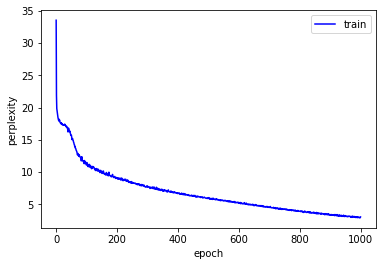

CPU times: user 5min 19s, sys: 1.22 s, total: 5min 20s
Wall time: 5min 24s


In [8]:
%%time
def grad_clipping(net, theta):
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

state = None
epochs = 1000
perplexity = []
for epoch in range(epochs):
  epoch_loss = []
  for X, Y in train_iter:
    y = Y.T.reshape(-1)
    X, y = X.cuda(), y.cuda()
    state = net.begin_state(batch_size=X.shape[0])
    y_hat, state = net(X, state)
    # state 是叶子节点，不可以直接设置grad
    state = (state[0].detach(),)
    l = loss(y_hat, y.long()).mean()
    epoch_loss.append(l.item())
    
    opt.zero_grad()
    l.backward()
    grad_clipping(net,1)
    opt.step()
  
  epoch_perplexity = np.exp(np.mean(epoch_loss))
  if (epoch+1)%50==0:
    print(f'epoch: {epoch+1}, perplexity:{epoch_perplexity:f}')
  perplexity.append(epoch_perplexity)

plt.plot(perplexity, label='train', color='b', linestyle='solid')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.legend()
plt.show()

In [9]:
def predict(prefix, num_preds, net, vocab, device=torch.device('cuda')):
  def get_word_order_tensor(sign, device):
    return torch.LongTensor([sign]).reshape(1,1).to(device)

  state = net.begin_state(batch_size=1, device=device)
  output = []

  for y in prefix:
    word_num = get_word_order_tensor(vocab[y], device)
    _, state = net(word_num, state)
    output.append(int(word_num))

  for _ in range(num_preds):
    word_num = get_word_order_tensor(output[-1], device)
    y, state = net(word_num, state)
    output.append(int(torch.argmax(y, axis=1).reshape(1)))
  return ''.join([vocab.idx_to_token[i] for i in output])

In [10]:
predict('time machine ', 40, net, vocab)

'time machine o erg time traveller travel and there ar'

## Torch Code

In [11]:
class RNNModel(nn.Module):
  '''循环神经网络'''
  def __init__(self, rnn_layer, vocab_size, **kwargs):
    super().__init__(**kwargs)
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    # 如果RNN是双向的(之后将介绍)，num_directions应该是2，否则应该是1
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(self.num_hiddens, self.vocab_size) 
    else:
      self.num_directions = 2
      self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
  
  def forward(self, inputs, state):
    X = F.one_hot(inputs.T.long(), self.vocab_size)
    X = X.to(torch.float32)
    Y, state = self.rnn(X, state)
    # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数) 
    # 它的输出形状是(时间步数*批量大小,词表大小)。
    output = self.linear(Y.reshape((-1, Y.shape[-1]))) 
    return output, state

  def begin_state(self, device, batch_size=1): 
    if not isinstance(self.rnn, nn.LSTM):
      # nn.GRU以张量作为隐状态
      return torch.zeros((self.num_directions * self.rnn.num_layers,
                             batch_size, self.num_hiddens),
                            device=device)
    else:
    # nn.LSTM以元组作为隐状态 
      return (torch.zeros((self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                    batch_size, self.num_hiddens), device=device))
      
def train_rnn(net, epochs, train_iter, loss, optim, 
              state=None, grad_clip_theta=1, device=torch.device('cuda')):
  # 梯度裁剪
  def grad_clipping(net, theta=grad_clip_theta):
    if isinstance(net, nn.Module):
      params = [p for p in net.parameters() if p.requires_grad]
    else:
      params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
      for param in params:
        param.grad[:] *= theta / norm

  loss = loss
  opt = optim
  state = state
  epochs = epochs
  perplexity = []

  net.to(device=device)
  for epoch in range(epochs):
    epoch_loss = []
    for X, Y in train_iter:
      y = Y.T.reshape(-1)
      X, y = X.to(device), y.to(device)
      state = net.begin_state(batch_size=X.shape[0], device=device)
      y_hat, state = net(X, state)
      # state 是叶子节点，不可以直接设置grad
      state = (state[0].detach(),)
      l = loss(y_hat, y.long()).mean()
      epoch_loss.append(l.item())
      
      opt.zero_grad()
      l.backward()
      grad_clipping(net)
      opt.step()
    epoch_perplexity = np.exp(np.mean(epoch_loss))
    if (epoch+1)%50==0:
      print(f'epoch: {epoch+1}, perplexity:{epoch_perplexity:f}')
    perplexity.append(epoch_perplexity)

  plt.plot(perplexity, label='train', color='b', linestyle='solid')
  plt.xlabel('epoch')
  plt.ylabel('perplexity')
  plt.legend()
  plt.show()

In [12]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)

In [13]:
model = d2l.RNNModel(lstm_layer, len(vocab))
model.cuda()

RNNModel(
  (rnn): LSTM(28, 256, num_layers=2)
  (linear): Linear(in_features=256, out_features=28, bias=True)
)

epoch: 50, perplexity:17.204945
epoch: 100, perplexity:13.372451
epoch: 150, perplexity:10.242225
epoch: 200, perplexity:8.359316
epoch: 250, perplexity:6.792055
epoch: 300, perplexity:4.713353
epoch: 350, perplexity:2.669985
epoch: 400, perplexity:1.858886
epoch: 450, perplexity:1.554754
epoch: 500, perplexity:1.356616


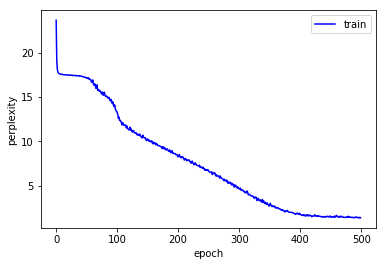

CPU times: user 18.3 s, sys: 431 ms, total: 18.8 s
Wall time: 19 s


In [14]:
%%time
loss = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=1)
train_rnn(model, epochs=500, train_iter=train_iter, loss=loss, optim=opt)

In [15]:
predict('time machine ', 40, model, vocab)

'time machine at mochat a digen along the time travell'